In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

import wget

import matplotlib.pyplot as plt
import librosa.display

import zipfile
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder  # OBBLIGATORIO DA USARE
from tensorflow.keras.utils import to_categorical  # OBBLIGATORIO DA USARE
from io import TextIOWrapper

# from tqdm.notebook import tqdm
from tqdm import tqdm
import requests


from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from scipy.signal import hilbert


import random
from scipy.signal import fftconvolve

from scipy.signal import hilbert
import numpy as np
import librosa
from tqdm import tqdm

In [2]:
def extract_zip_if_needed(zip_path, extract_to=None):
    """
    Estrae il file ZIP se la cartella di destinazione non esiste già.

    Args:
        zip_path (str): Percorso al file ZIP
        extract_to (str, optional): Cartella dove estrarre i file. Se None, usa il nome del file ZIP.

    Returns:
        str: Percorso alla cartella estratta
    """

    # Se la directory di estrazione non è specificata, usa il nome del file ZIP
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]

    # Controlla se la directory di estrazione esiste già
    if os.path.exists(extract_to) and os.path.isdir(extract_to):
        print(f"La directory '{extract_to}' esiste già, l'estrazione verrà saltata.")
        return extract_to

    # Estrai lo ZIP se esiste
    if os.path.exists(zip_path):
        print(f"Estrazione di '{zip_path}' in '{extract_to}'...")

        # Ottieni la lista dei file nello ZIP per la progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            total_files = len(file_list)

        # Estrai i file con progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            os.makedirs(extract_to, exist_ok=True)
            for file in tqdm(file_list, desc="Estrazione files", total=total_files):
                zip_ref.extract(file, extract_to)

        print(f"Estrazione completata in '{extract_to}'")
    else:
        raise FileNotFoundError(f"Il file ZIP '{zip_path}' non esiste.")

    return extract_to



def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """ Import IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file with all WAV files
    Returns:
        df_dataset (pd.Dataframe): File-wise metadata
            Columns:
                'file': WAV filename,
                'is_background': True if recording contains background noise (no vehicle), False else
                'date_time': Recording time (YYYY-MM-DD-HH-mm)
                'location': Recording location
                'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
                'sample_pos': Sample position (centered) within the original audio recording,
                'daytime': M(orning) or (A)fternoon,
                'weather': (D)ry or (W)et road condition,
                'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
                'source_direction': Source direction of passing vehicle: from (L)eft or from (R)ight,
                'microphone': (SE)= (high-quality) sE8 microphones, (ME) = (low-quality) MEMS microphones (ICS-43434),
                'channel': Original stereo pair channel (12) or (34)
    """

    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                           'is_background': is_background,
                           'date_time': date_time,
                           'location': location,
                           'speed_kmh': speed_kmh,
                           'sample_pos': sample_pos,
                           'daytime': daytime,
                           'weather': weather,
                           'vehicle': vehicle,
                           'source_direction': source_direction,
                           'microphone': mic,
                           'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                                   'source_direction', 'microphone', 'channel'))

    return df_dataset

In [3]:
# Percorso assoluto del file ZIP
# ZIP_PATH = "/Volumes/Extreme SSD/IDMT_Traffic.zip" # di Stefano
ZIP_PATH = "IDMT_Traffic.zip"
# AUDIO_DIR = "IDMT_Traffic/audio/"
# ANN_DIR = "IDMT_Traffic/annotation/idmt_traffic_all.txt"

# Download file if it doesn't exist
if not os.path.exists(ZIP_PATH):
    url = "https://zenodo.org/records/7551553/files/IDMT_Traffic.zip?download=1"
    print(f"Downloading {ZIP_PATH}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(ZIP_PATH, 'wb') as file:
        with tqdm(
                desc=ZIP_PATH,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
    print("Download complete!")
else:
    print(f"File {ZIP_PATH} already exists, skipping download.")


# Estrai lo ZIP se necessario
extracted_dir = extract_zip_if_needed(ZIP_PATH)

AUDIO_DIR_PATH = os.path.join(extracted_dir, "IDMT_Traffic/audio/")
ANN_FILE_PATH = os.path.join(extracted_dir, "IDMT_Traffic/annotation/idmt_traffic_all.txt")

all_audio_files = [os.path.join(AUDIO_DIR_PATH, f) for f in os.listdir(AUDIO_DIR_PATH) if f.endswith('.wav')]
print(f"\nNumero totale di file audio trovati: {len(all_audio_files)}")

# Leggi il file di annotazione
# df_dataset = pd.read_csv(ANN_FILE_PATH, sep="\t", header=None)
df_dataset = import_idmt_traffic_dataset(ANN_FILE_PATH)
vehicle = df_dataset["vehicle"]
direction = df_dataset["source_direction"]
print(np.unique(vehicle))
print(np.unique(direction))


# LABEL ENCODING
# Use separate encoders for different label types
le_vehicle = LabelEncoder()
labels_encoded_vehicle = le_vehicle.fit_transform(vehicle)
labels_cat_vehicles = to_categorical(labels_encoded_vehicle)

le_direction = LabelEncoder()
labels_encoded_direction = le_direction.fit_transform(direction)
labels_cat_direction = to_categorical(labels_encoded_direction)

File IDMT_Traffic.zip already exists, skipping download.
La directory 'IDMT_Traffic' esiste già, l'estrazione verrà saltata.

Numero totale di file audio trovati: 17506
['B' 'C' 'M' 'None' 'T']
['L' 'None' 'R']


In [5]:
def analyze_audio_channels(file_list):
    """
    Analizza il numero di canali audio nei file del database.

    Args:
        file_list: Lista di percorsi ai file audio

    Returns:
        tuple: (conteggio_stereo, conteggio_mono, dettagli_per_file)
    """
    mono_count = 0
    stereo_count = 0
    file_details = []

    # Loop attraverso tutti i file con progress bar
    for file_path in tqdm(file_list, desc="Analisi file audio"):
        try:
            # Carica il file preservando i canali
            y, sr = librosa.load(file_path, sr=None, mono=False)

            # Controlla se è mono o stereo
            if y.ndim == 1:  # Mono (1 dimensione)
                mono_count += 1
                channels = 1
            else:  # Stereo (2 dimensioni)
                stereo_count += 1
                channels = y.shape[0]

            # Aggiungi dettagli
            file_name = os.path.basename(file_path)
            file_details.append({
                'file': file_name,
                'channels': channels,
                'tipo': 'mono' if channels == 1 else 'stereo'
            })

        except Exception as e:
            print(f"Errore nell'analisi del file {file_path}: {e}")

    return stereo_count, mono_count, file_details

# Esegui l'analisi
stereo_count, mono_count, details = analyze_audio_channels(all_audio_files)

# Stampa i risultati
print("\n------ ANALISI CANALI AUDIO ------")
print(f"Numero di file stereo: {stereo_count}")
print(f"Numero di file mono: {mono_count}")
print(f"Totale file analizzati: {stereo_count + mono_count}")
print(f"Percentuale stereo: {stereo_count/(stereo_count + mono_count)*100:.1f}%")
print(f"Percentuale mono: {mono_count/(stereo_count + mono_count)*100:.1f}%")

# Opzionale: salva i dettagli in un CSV
import pandas as pd
df_details = pd.DataFrame(details)
print("\nPrimi 5 file analizzati:")
print(df_details.head())

# Opzionale: salva in CSV
# df_details.to_csv("audio_channels_analysis.csv", index=False)

Analisi file audio: 100%|██████████| 17506/17506 [03:38<00:00, 80.11it/s]


------ ANALISI CANALI AUDIO ------
Numero di file stereo: 17506
Numero di file mono: 0
Totale file analizzati: 17506
Percentuale stereo: 100.0%
Percentuale mono: 0.0%

Primi 5 file analizzati:
                                                file  channels    tipo
0  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...         2  stereo
1  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...         2  stereo
2  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...         2  stereo
3  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...         2  stereo
4  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1026944...         2  stereo


In [35]:
# ----------------------------------------------------------------------
# DATA AUGMENTATION
# ----------------------------------------------------------------------

# 1. Rumore
def add_noise(y, snr_db=10):
    signal_power = np.mean(y**2)
    snr = 10**(snr_db / 10)
    noise_power = signal_power / snr
    noise = np.random.normal(0, np.sqrt(noise_power), size=y.shape)
    return y + noise

# 2. Pitch shift

def apply_pitch_shift(y, sr):
    is_stereo = y.ndim > 1
    
    if is_stereo:
        # Gestione stereo (separatamente per ogni canale)
        ch1 = librosa.effects.pitch_shift(y[0], sr=sr, n_steps=2)
        ch2 = librosa.effects.pitch_shift(y[1], sr=sr, n_steps=2)
        
        # Ricombina i canali
        return np.array([ch1, ch2])
    else:
        # Caso mono originale
        return librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

# 3. Time stretch

def apply_time_stretch(y, rate=1.2):
    is_stereo = y.ndim > 1
    
    if is_stereo:
        # Gestione stereo (separatamente per ogni canale)
        ch1 = librosa.effects.time_stretch(y[0], rate=rate)
        ch2 = librosa.effects.time_stretch(y[1], rate=rate)
        
        if len(ch1) > len(y[0]):
            ch1 = ch1[:len(y[0])]
        elif len(ch1) < len(y[0]):
            ch1= np.pad(ch1, (0, len(y[0])-len(ch1)), mode='constant', constant_values=(0,0))

        if len(ch2) > len(y[1]):
            ch2 = ch2[:len(y[1])]
        elif len(ch2) < len(y[1]):
            ch2 = np.pad(ch2, (0, len(y[1])-len(ch2)), mode='constant', constant_values=(0,0))
        
        # print(len(y[0]))
        # print(len(y[1]))
        # print(len(ch1))
        # print(len(ch2))

        return np.array([ch1, ch2])
    else:
        # Caso mono originale
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        if len(y_stretched) > len(y):
            return y_stretched[:len(y)]
        else:
            return np.pad(y_stretched, (0, len(y) - len(y_stretched)), mode='constant')

'''
def apply_random_crop(y, sr, target_duration=2.0):
    # Rileva se l'audio è stereo o mono
    is_stereo = y.ndim > 1
    
    # Ottiene il numero di campioni correttamente
    if is_stereo:
        n_samples = len(y[0])  # Per audio stereo
    else:
        n_samples = len(y)      # Per audio mono
    
    # Calcola parametri di crop
    crop_duration = random.uniform(0.5, target_duration - 0.01)
    crop_length = np.floor(crop_duration * sr)
    target_length = np.floor(target_duration * sr)
    
    # Gestisce il caso in cui l'audio è più corto della lunghezza di crop
    if n_samples <= crop_length:
        y_crop = y
    else:
        start = np.random.randint(0, n_samples - crop_length)
        if is_stereo:
            y_crop = y[:, start:start + crop_length]  # Slice per stereo
        else:
            y_crop = y[start:start + crop_length]     # Slice per mono
    
    # Padding alla lunghezza target
    if is_stereo:
        crop_samples = y_crop.shape[1]
        y_padded = np.pad(y_crop, ((0, 0), (0, target_length - crop_samples)), mode='constant')
    else:
        y_padded = np.pad(y_crop, (0, target_length - len(y_crop)), mode='constant')
    
    print(len(y[0]))
    print(len(y[1]))
    print(len(y_padded[0]))
    print(len(y_padded[1]))
    
    return y_padded
'''

# Lista delle augmentazioni disponibili
AUGMENTATION_FUNCTIONS = [
    apply_pitch_shift,
    apply_time_stretch,
    add_noise,
    # apply_random_crop
]

# Funzione principale di augmentazione
def augment_audio(y, sr, n_augmentations=2):
    """
    Applica n_augmentations funzioni di augmentation casuali all'audio.
    
    Args:
        y: array audio di input (stereo o mono)
        sr: sample rate
        n_augmentations: numero di augmentations da applicare in sequenza
    
    Returns:
        array audio modificato nello stesso formato dell'input
    """
    # Seleziona n_augmentations funzioni casuali dalla lista disponibile
    selected_augs = random.sample(AUGMENTATION_FUNCTIONS, k=n_augmentations)
    
    # Audio da modificare (inizialmente l'originale)
    y_aug = y.copy()
    
    # Applica le augmentations in sequenza
    for aug_fn in selected_augs:
        args = aug_fn.__code__.co_varnames
        if 'sr' in args and 'target_duration' in args:
            y_aug = aug_fn(y_aug, sr, target_duration=2.0)
        elif 'sr' in args:
            y_aug = aug_fn(y_aug, sr)
        else:
            y_aug = aug_fn(y_aug)
    
    return y_aug


In [36]:
# FEATURE EXTRACTION

spectrograms = []
spectral_centroids = []
spectral_rolloffs = []
spectral_contrasts = []
low_freq_energies = []
fixed_length = None

ild_features = []
ipd_features = []

def normalize_spectrogram(spec):
    spec_min = np.min(spec)
    spec_max = np.max(spec)
    return (spec - spec_min) / (spec_max - spec_min + 1e-6)

def compute_ild_ipd(left, right):
    """
    Calcola ILD e IPD da due canali separati.
    """
    eps = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        ild = 20 * np.log10(np.abs(left) / (np.abs(right) + eps))
        ild[np.isinf(ild)] = 0  # sostituisci inf con 0
    
    analytic_left = hilbert(left)
    analytic_right = hilbert(right)
    phase_left = np.angle(analytic_left)
    phase_right = np.angle(analytic_right)
    ipd = phase_left - phase_right
    ipd = (ipd + np.pi) % (2 * np.pi) - np.pi
    
    ild_stats = np.array([np.mean(ild), np.std(ild), np.max(ild), np.median(ild)])
    ipd_stats = np.array([np.mean(ipd), np.std(ipd), np.max(ipd), np.median(ipd)])
    
    return ild_stats, ipd_stats


# --- Parametri comuni ---
n_fft = 2048
hop_length = 512
n_mels = 128


file_counter = 0
for audio_path in all_audio_files[:]:

    y, sr = librosa.load(audio_path, sr=None, mono=False)

    file_counter += 1

    # Augment 1 sample every 5
    if file_counter % 5 == 0:
        y = augment_audio(y, sr, n_augmentations=2)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


    # 1 centroide per ogni frame
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # 1 rolloff per ogni frame
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    # 1 contrasto per banda (default 6+1 bande)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

    low_freq_energy = np.sum(mel_spectrogram[:10, :]) / (np.sum(mel_spectrogram) + 1e-10)

    if fixed_length is None:
        fixed_length = mel_spectrogram_db.shape[1]
    
    # Padding o troncamento
    if mel_spectrogram_db.shape[1] < fixed_length:
        mel_spectrogram_db = np.pad(mel_spectrogram_db,
                                    ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])),
                                    mode='constant')
    else:
        mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]
    
    # Normalizzazione
    mel_spectrogram_db = normalize_spectrogram(mel_spectrogram_db)
    
    spectrograms.append(mel_spectrogram_db) 
    spectral_centroids.append(spectral_centroid)
    spectral_rolloffs.append(spectral_rolloff)
    spectral_contrasts.append(spectral_contrast)
    low_freq_energies.append(low_freq_energy)      

    # ILD/IPD stats
    ild_stats, ipd_stats = compute_ild_ipd(y[0], y[1])  # Assuming stereo audio
    ild_features.append(ild_stats)
    ipd_features.append(ipd_stats)


spectrograms = np.array(spectrograms)
spectrograms = spectrograms / np.max(np.abs(spectrograms))

spectral_centroids = np.array(spectral_centroids)
spectral_rolloffs = np.array(spectral_rolloffs)
spectral_contrasts = np.array(spectral_contrasts)
low_freq_energies = np.array(low_freq_energies)

ild_features = np.array(ild_features)
ipd_features = np.array(ipd_features)

input_shape = spectrograms.shape[1:]

print("Spectrograms shape:", spectrograms.shape)
print("Spectral Centroids shape:", spectral_centroids.shape)
print("Spectral Rolloffs shape:", spectral_rolloffs.shape)
print("Spectral Contrasts shape:", spectral_contrasts.shape)
print("Low freq energies shape:", low_freq_energies.shape)
print("ILD features shape:", ild_features.shape)
print("IPD features shape:", ipd_features.shape)
print("Input shape for model:", input_shape)


Spectrograms shape: (17506, 2, 128, 188)
Spectral Centroids shape: (17506, 1, 188)
Spectral Rolloffs shape: (17506, 1, 188)
Spectral Contrasts shape: (17506, 2, 188)
Low freq energies shape: (17506,)
ILD features shape: (17506, 4)
IPD features shape: (17506, 4)
Input shape for model: (2, 128, 188)


In [37]:
# 1. Estrai statistiche dalle feature temporali
def extract_stats(feature):
    # First calculate statistics across the time/feature dimension (axis=2)
    mean_val = np.mean(feature, axis=2)
    std_val = np.std(feature, axis=2)
    max_val = np.max(feature, axis=2)
    median_val = np.median(feature, axis=2)
    
    # Reshape to remove the middle dimension of 1 and stack the statistics along a new dimension
    # This will result in shape (17506, 4)
    return np.column_stack([
        mean_val.reshape(-1),
        std_val.reshape(-1),
        max_val.reshape(-1),
        median_val.reshape(-1)
    ])

# Applica a centroid e rolloff
centroid_stats = extract_stats(spectral_centroids)  # (17506, 4)
rolloff_stats = extract_stats(spectral_rolloffs)    # (17506, 4) 
contrast_stats_left = extract_stats(spectral_contrasts[:, :spectral_contrasts.shape[1] // 2, :])  # Left channel
contrast_stats_right = extract_stats(spectral_contrasts[:, spectral_contrasts.shape[1] // 2:, :])  # Right channel

print(f"Centroid stats shape: {centroid_stats.shape}")
print(f"Rolloff stats shape: {rolloff_stats.shape}")
print(f"Contrast stats shape (left): {contrast_stats_left.shape}")
print(f"Contrast stats shape (right): {contrast_stats_right.shape}")
print(f"Low frequency energies shape: {low_freq_energies.shape}")
print(f"ILD features shape: {ild_features.shape}")
print(f"IPD features shape: {ipd_features.shape}")

# Combina tutte le feature audio (tranne spettrogrammi)
audio_features = np.concatenate([
    centroid_stats,                     # (17506, 4)
    rolloff_stats,                      # (17506, 4) 
    contrast_stats_left,                # (17506, 4)
    contrast_stats_right,               # (17506, 4)
    low_freq_energies.reshape(-1, 1),   # (17506, 1)
    ild_features,                       # (17506, 4)
    ipd_features                        # (17506, 4) 
], axis=1)  # Risultato: (17506, 25)

# "Cleaning" of audio features
audio_features = np.nan_to_num(audio_features, nan=0.0, posinf=0.0, neginf=0.0)

# Normalizza le feature audio
scaler = StandardScaler()
audio_features_scaled = scaler.fit_transform(audio_features)

print()
print(audio_features_scaled.shape)

Centroid stats shape: (17506, 4)
Rolloff stats shape: (17506, 4)
Contrast stats shape (left): (17506, 4)
Contrast stats shape (right): (17506, 4)
Low frequency energies shape: (17506,)
ILD features shape: (17506, 4)
IPD features shape: (17506, 4)

(17506, 25)


In [38]:
# ------------------------------------------------------------------------------
# STEREO
# ------------------------------------------------------------------------------

# Dataset Split corretto per multi-input e multi-output (feature audio e spettrogrammi, più tipi di etichette)

# Reshape per CNN (aggiunge canale)
print(f"Dimensione spettrogrammi prima del reshape: {spectrograms.shape}")
# spectrograms_reshaped = spectrograms.reshape(spectrograms.shape[0], spectrograms.shape[1], spectrograms.shape[2], 1)
spectrograms_reshaped = spectrograms.transpose(0, 2, 3, 1)  # (17506, 128, 188, 2)
print(f"Dimensione spettrogrammi dopo il reshape: {spectrograms_reshaped.shape}")

# 1. Primo split: Train (70%) e Temporary (30%)
X_train, X_temp, audio_features_train, audio_features_temp, y_train_vehicle, y_temp_vehicle, y_train_direction, y_temp_direction = train_test_split(
    spectrograms_reshaped,
    audio_features_scaled,  # Feature audio per il secondo ramo
    labels_cat_vehicles,
    labels_cat_direction,
    test_size=0.30,         # 70% train, 30% temporary
    random_state=42,
    shuffle=True
)

# 2. Secondo split: Temporary in Validation (15%) e Test (15%)
X_val, X_test, audio_features_val, audio_features_test, y_val_vehicle, y_test_vehicle, y_val_direction, y_test_direction = train_test_split(
    X_temp,
    audio_features_temp,   # Feature audio temporanee da dividere
    y_temp_vehicle,
    y_temp_direction,
    test_size=0.50,        # 15% validation, 15% test (metà del 30% temporary)
    random_state=42,
    shuffle=True
)

print()
print(f"Train set: {len(X_train)} campioni")
print(f"Validation set: {len(X_val)} campioni")
print(f"Test set: {len(X_test)} campioni")

# Verifica dimensioni input per il modello
print(f"Dimensione input spettrogrammi: {X_train.shape[1:]}")
print(f"Dimensione input feature audio: {audio_features_train.shape[1:]}")

Dimensione spettrogrammi prima del reshape: (17506, 2, 128, 188)
Dimensione spettrogrammi dopo il reshape: (17506, 128, 188, 2)

Train set: 12254 campioni
Validation set: 2626 campioni
Test set: 2626 campioni
Dimensione input spettrogrammi: (128, 188, 2)
Dimensione input feature audio: (25,)


In [39]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 11
# ------------------------------------------------------------------------------

'''
Come modello 10, ma con data aug
'''

# Definizione del modello

# 1. Ramo CNN per spettrogrammi
input_spectrogram = tf.keras.Input(shape=spectrograms_reshaped.shape[1:], name='spectrogram_input')

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(input_spectrogram)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Flatten()(x1)


# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)

# Fusione dei due rami
merged = tf.keras.layers.Concatenate()([x1, x2])

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(merged)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Output branch per i veicoli
vehicle_output = tf.keras.layers.Dense(5, activation='softmax', name='vehicle_output')(x)

# Output branch per la direzione (3 classi: left, right, none)
direction_output = tf.keras.layers.Dense(3, activation='softmax', name='direction_output')(x)


# Modello completo con doppio output
model_11 = tf.keras.Model(
    inputs=[input_spectrogram, input_features],
    outputs=[vehicle_output, direction_output]
)

model_11.summary()


# Compilation con doppio obiettivo e perdita
model_11.compile(
    optimizer='adam',
    loss={
        'vehicle_output': 'categorical_crossentropy',
        'direction_output': 'categorical_crossentropy'
    },
    metrics={
        'vehicle_output': ['accuracy'],
        'direction_output': ['accuracy']
    },
    loss_weights={
        'vehicle_output': 1.0,
        'direction_output': 1.0  # Puoi bilanciare l'importanza degli output
    }
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_11.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 128, 188,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 186,  │      1,216 │ spectrogram_inpu… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 93,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 93,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 91,    │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 45,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 45,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 43,    │     18,464 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 21,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,664 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 14, 21,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 19,    │      4,624 │ dropout_2[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 9, 16)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 6, 9, 16)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,579,160 (6.02 MB)

 Trainable params: 1,579,160 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Per l'addestramento, dovrai passare entrambi gli output
history_11 = model_11.fit(
    [X_train, audio_features_train],  # inputs
    {
        'vehicle_output': y_train_vehicle,
        'direction_output': y_train_direction
    },  # targets
    epochs=150,
    batch_size=32,
    validation_data=(
        [X_val, audio_features_val],
        {
            'vehicle_output': y_val_vehicle,
            'direction_output': y_val_direction
        }
    ),
    callbacks=[early_stopping, model_checkpoint]
)

# loss è la somma di direction_output_loss e vehicle_output_loss

Epoch 1/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - direction_output_accuracy: 0.6067 - direction_output_loss: 0.7780 - loss: 1.5200 - vehicle_output_accuracy: 0.7283 - vehicle_output_loss: 0.7420

383/383 ━━━━━━━━━━━━━━━━━━━━ 60s 146ms/step - direction_output_accuracy: 0.6068 - direction_output_loss: 0.7777 - loss: 1.5193 - vehicle_output_accuracy: 0.7285 - vehicle_output_loss: 0.7416 - val_direction_output_accuracy: 0.6698 - val_direction_output_loss: 0.6482 - val_loss: 1.2952 - val_vehicle_output_accuracy: 0.7749 - val_vehicle_output_loss: 0.6519
Epoch 2/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - direction_output_accuracy: 0.7436 - direction_output_loss: 0.5247 - loss: 0.9846 - vehicle_output_accuracy: 0.8460 - vehicle_output_loss: 0.4599

383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - direction_output_accuracy: 0.7437 - direction_output_loss: 0.5246 - loss: 0.9845 - vehicle_output_accuracy: 0.8460 - vehicle_output_loss: 0.4599 - val_direction_output_accuracy: 0.8412 - val_direction_output_loss: 0.4301 - val_loss: 0.9120 - val_vehicle_output_accuracy: 0.8751 - val_vehicle_output_loss: 0.4798
Epoch 3/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - direction_output_accuracy: 0.8375 - direction_output_loss: 0.3835 - loss: 0.7851 - vehicle_output_accuracy: 0.8697 - vehicle_output_loss: 0.4017

383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - direction_output_accuracy: 0.8375 - direction_output_loss: 0.3834 - loss: 0.7850 - vehicle_output_accuracy: 0.8698 - vehicle_output_loss: 0.4016 - val_direction_output_accuracy: 0.8416 - val_direction_output_loss: 0.3645 - val_loss: 0.7727 - val_vehicle_output_accuracy: 0.8793 - val_vehicle_output_loss: 0.4047
Epoch 4/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 73s 189ms/step - direction_output_accuracy: 0.8821 - direction_output_loss: 0.2935 - loss: 0.6322 - vehicle_output_accuracy: 0.8877 - vehicle_output_loss: 0.3387 - val_direction_output_accuracy: 0.8008 - val_direction_output_loss: 0.4565 - val_loss: 1.0117 - val_vehicle_output_accuracy: 0.7860 - val_vehicle_output_loss: 0.5555
Epoch 5/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - direction_output_accuracy: 0.9167 - direction_output_loss: 0.2234 - loss: 0.5535 - vehicle_output_accuracy: 0.8911 - vehicle_output_loss: 0.3301

383/383 ━━━━━━━━━━━━━━━━━━━━ 75s 195ms/step - direction_output_accuracy: 0.9167 - direction_output_loss: 0.2234 - loss: 0.5535 - vehicle_output_accuracy: 0.8911 - vehicle_output_loss: 0.3301 - val_direction_output_accuracy: 0.9379 - val_direction_output_loss: 0.2024 - val_loss: 0.5388 - val_vehicle_output_accuracy: 0.8995 - val_vehicle_output_loss: 0.3336
Epoch 6/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - direction_output_accuracy: 0.9291 - direction_output_loss: 0.1880 - loss: 0.4779 - vehicle_output_accuracy: 0.9048 - vehicle_output_loss: 0.2899

383/383 ━━━━━━━━━━━━━━━━━━━━ 79s 206ms/step - direction_output_accuracy: 0.9291 - direction_output_loss: 0.1881 - loss: 0.4780 - vehicle_output_accuracy: 0.9048 - vehicle_output_loss: 0.2899 - val_direction_output_accuracy: 0.9452 - val_direction_output_loss: 0.1547 - val_loss: 0.4571 - val_vehicle_output_accuracy: 0.9075 - val_vehicle_output_loss: 0.2994
Epoch 7/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - direction_output_accuracy: 0.9342 - direction_output_loss: 0.1754 - loss: 0.4764 - vehicle_output_accuracy: 0.8989 - vehicle_output_loss: 0.3011

383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 211ms/step - direction_output_accuracy: 0.9342 - direction_output_loss: 0.1754 - loss: 0.4765 - vehicle_output_accuracy: 0.8989 - vehicle_output_loss: 0.3011 - val_direction_output_accuracy: 0.9528 - val_direction_output_loss: 0.1521 - val_loss: 0.4301 - val_vehicle_output_accuracy: 0.9143 - val_vehicle_output_loss: 0.2746
Epoch 8/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - direction_output_accuracy: 0.9400 - direction_output_loss: 0.1712 - loss: 0.4705 - vehicle_output_accuracy: 0.8992 - vehicle_output_loss: 0.2993

383/383 ━━━━━━━━━━━━━━━━━━━━ 80s 209ms/step - direction_output_accuracy: 0.9400 - direction_output_loss: 0.1712 - loss: 0.4704 - vehicle_output_accuracy: 0.8992 - vehicle_output_loss: 0.2992 - val_direction_output_accuracy: 0.9573 - val_direction_output_loss: 0.1331 - val_loss: 0.4088 - val_vehicle_output_accuracy: 0.9151 - val_vehicle_output_loss: 0.2730
Epoch 9/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 79s 207ms/step - direction_output_accuracy: 0.9411 - direction_output_loss: 0.1695 - loss: 0.4549 - vehicle_output_accuracy: 0.9046 - vehicle_output_loss: 0.2854 - val_direction_output_accuracy: 0.9269 - val_direction_output_loss: 0.1947 - val_loss: 0.5612 - val_vehicle_output_accuracy: 0.8854 - val_vehicle_output_loss: 0.3638
Epoch 10/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - direction_output_accuracy: 0.9474 - direction_output_loss: 0.1484 - loss: 0.4282 - vehicle_output_accuracy: 0.9071 - vehicle_output_loss: 0.2798

383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 212ms/step - direction_output_accuracy: 0.9474 - direction_output_loss: 0.1484 - loss: 0.4282 - vehicle_output_accuracy: 0.9071 - vehicle_output_loss: 0.2798 - val_direction_output_accuracy: 0.9634 - val_direction_output_loss: 0.1126 - val_loss: 0.3573 - val_vehicle_output_accuracy: 0.9196 - val_vehicle_output_loss: 0.2414
Epoch 11/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - direction_output_accuracy: 0.9504 - direction_output_loss: 0.1420 - loss: 0.4028 - vehicle_output_accuracy: 0.9095 - vehicle_output_loss: 0.2609

383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 211ms/step - direction_output_accuracy: 0.9504 - direction_output_loss: 0.1420 - loss: 0.4028 - vehicle_output_accuracy: 0.9095 - vehicle_output_loss: 0.2609 - val_direction_output_accuracy: 0.9600 - val_direction_output_loss: 0.1044 - val_loss: 0.3433 - val_vehicle_output_accuracy: 0.9212 - val_vehicle_output_loss: 0.2364
Epoch 12/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 210ms/step - direction_output_accuracy: 0.9566 - direction_output_loss: 0.1247 - loss: 0.3741 - vehicle_output_accuracy: 0.9149 - vehicle_output_loss: 0.2493 - val_direction_output_accuracy: 0.9650 - val_direction_output_loss: 0.1128 - val_loss: 0.3713 - val_vehicle_output_accuracy: 0.9235 - val_vehicle_output_loss: 0.2562
Epoch 13/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 212ms/step - direction_output_accuracy: 0.9538 - direction_output_loss: 0.1213 - loss: 0.3661 - vehicle_output_accuracy: 0.9151 - vehicle_output_loss: 0.2448 - val_direction_output_accuracy: 0.9631 - val_direction_output_loss

383/383 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - direction_output_accuracy: 0.9602 - direction_output_loss: 0.1130 - loss: 0.3490 - vehicle_output_accuracy: 0.9181 - vehicle_output_loss: 0.2360 - val_direction_output_accuracy: 0.9650 - val_direction_output_loss: 0.1057 - val_loss: 0.3374 - val_vehicle_output_accuracy: 0.9273 - val_vehicle_output_loss: 0.2288
Epoch 16/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - direction_output_accuracy: 0.9646 - direction_output_loss: 0.1091 - loss: 0.3393 - vehicle_output_accuracy: 0.9185 - vehicle_output_loss: 0.2302 - val_direction_output_accuracy: 0.9627 - val_direction_output_loss: 0.1101 - val_loss: 0.3576 - val_vehicle_output_accuracy: 0.9208 - val_vehicle_output_loss: 0.2448
Epoch 17/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - direction_output_accuracy: 0.9596 - direction_output_loss: 0.1129 - loss: 0.3456 - vehicle_output_accuracy: 0.9204 - vehicle_output_loss: 0.2327

383/383 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - direction_output_accuracy: 0.9596 - direction_output_loss: 0.1129 - loss: 0.3456 - vehicle_output_accuracy: 0.9204 - vehicle_output_loss: 0.2327 - val_direction_output_accuracy: 0.9650 - val_direction_output_loss: 0.0952 - val_loss: 0.3109 - val_vehicle_output_accuracy: 0.9280 - val_vehicle_output_loss: 0.2134
Epoch 18/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 84s 220ms/step - direction_output_accuracy: 0.9620 - direction_output_loss: 0.1092 - loss: 0.3407 - vehicle_output_accuracy: 0.9171 - vehicle_output_loss: 0.2315 - val_direction_output_accuracy: 0.9695 - val_direction_output_loss: 0.0918 - val_loss: 0.3208 - val_vehicle_output_accuracy: 0.9280 - val_vehicle_output_loss: 0.2264
Epoch 19/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 84s 219ms/step - direction_output_accuracy: 0.9659 - direction_output_loss: 0.1011 - loss: 0.3323 - vehicle_output_accuracy: 0.9161 - vehicle_output_loss: 0.2312 - val_direction_output_accuracy: 0.9650 - val_direction_output_loss

383/383 ━━━━━━━━━━━━━━━━━━━━ 168s 320ms/step - direction_output_accuracy: 0.9743 - direction_output_loss: 0.0758 - loss: 0.2757 - vehicle_output_accuracy: 0.9281 - vehicle_output_loss: 0.1999 - val_direction_output_accuracy: 0.9703 - val_direction_output_loss: 0.0844 - val_loss: 0.3083 - val_vehicle_output_accuracy: 0.9280 - val_vehicle_output_loss: 0.2213
Epoch 26/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 138s 360ms/step - direction_output_accuracy: 0.9729 - direction_output_loss: 0.0758 - loss: 0.2681 - vehicle_output_accuracy: 0.9288 - vehicle_output_loss: 0.1923 - val_direction_output_accuracy: 0.9680 - val_direction_output_loss: 0.0992 - val_loss: 0.3526 - val_vehicle_output_accuracy: 0.9288 - val_vehicle_output_loss: 0.2509
Epoch 27/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 144s 375ms/step - direction_output_accuracy: 0.9745 - direction_output_loss: 0.0755 - loss: 0.2776 - vehicle_output_accuracy: 0.9260 - vehicle_output_loss: 0.2021 - val_direction_output_accuracy: 0.9657 - val_direction_output_l

383/383 ━━━━━━━━━━━━━━━━━━━━ 139s 362ms/step - direction_output_accuracy: 0.9743 - direction_output_loss: 0.0730 - loss: 0.2673 - vehicle_output_accuracy: 0.9290 - vehicle_output_loss: 0.1942 - val_direction_output_accuracy: 0.9733 - val_direction_output_loss: 0.0751 - val_loss: 0.2837 - val_vehicle_output_accuracy: 0.9307 - val_vehicle_output_loss: 0.2059
Epoch 33/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 136s 354ms/step - direction_output_accuracy: 0.9808 - direction_output_loss: 0.0563 - loss: 0.2395 - vehicle_output_accuracy: 0.9328 - vehicle_output_loss: 0.1832 - val_direction_output_accuracy: 0.9684 - val_direction_output_loss: 0.0979 - val_loss: 0.3195 - val_vehicle_output_accuracy: 0.9242 - val_vehicle_output_loss: 0.2191
Epoch 34/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 124s 325ms/step - direction_output_accuracy: 0.9742 - direction_output_loss: 0.0752 - loss: 0.2757 - vehicle_output_accuracy: 0.9301 - vehicle_output_loss: 0.2005 - val_direction_output_accuracy: 0.9676 - val_direction_output_l

383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 139ms/step - direction_output_accuracy: 0.9864 - direction_output_loss: 0.0396 - loss: 0.1846 - vehicle_output_accuracy: 0.9468 - vehicle_output_loss: 0.1451 - val_direction_output_accuracy: 0.9745 - val_direction_output_loss: 0.0796 - val_loss: 0.2827 - val_vehicle_output_accuracy: 0.9337 - val_vehicle_output_loss: 0.2005
Epoch 57/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - direction_output_accuracy: 0.9897 - direction_output_loss: 0.0285 - loss: 0.1680 - vehicle_output_accuracy: 0.9481 - vehicle_output_loss: 0.1395 - val_direction_output_accuracy: 0.9703 - val_direction_output_loss: 0.1142 - val_loss: 0.3857 - val_vehicle_output_accuracy: 0.9158 - val_vehicle_output_loss: 0.2683
Epoch 58/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 137ms/step - direction_output_accuracy: 0.9852 - direction_output_loss: 0.0420 - loss: 0.1899 - vehicle_output_accuracy: 0.9451 - vehicle_output_loss: 0.1479 - val_direction_output_accuracy: 0.9676 - val_direction_output_loss

In [49]:
# TEST per modello multi-output
best_model_11 = tf.keras.models.load_model('best_model_11.h5')

# Valutazione del modello con entrambi gli output
results = best_model_11.evaluate(
    [X_test, audio_features_test],
    {
        'vehicle_output': y_test_vehicle,
        'direction_output': y_test_direction
    },
    verbose=1
)

# Estrai e stampa le metriche
print("\n--- Risultati test modello multi-output ---")
print(f"Loss totale: {results[0]:.4f}")
print(f"Vehicle output loss: {results[1]:.4f}")
print(f"Direction output loss: {results[2]:.4f}")
print(f"Vehicle accuracy: {results[3]:.4f}")
print(f"Direction accuracy: {results[4]:.4f}")

# Genera predizioni
y_pred_probs = best_model_11.predict([X_test, audio_features_test])
vehicle_pred_probs = y_pred_probs[0]  # Prima uscita: vehicle
direction_pred_probs = y_pred_probs[1]  # Seconda uscita: direction

# Converti probabilità in categorie
vehicle_pred = np.argmax(vehicle_pred_probs, axis=1)
direction_pred = np.argmax(direction_pred_probs, axis=1)
vehicle_true = np.argmax(y_test_vehicle, axis=1)
direction_true = np.argmax(y_test_direction, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - direction_output_accuracy: 0.9724 - direction_output_loss: 0.0828 - loss: 0.3257 - vehicle_output_accuracy: 0.9289 - vehicle_output_loss: 0.2428

--- Risultati test modello multi-output ---
Loss totale: 0.3283
Vehicle output loss: 0.2459
Direction output loss: 0.0808
Vehicle accuracy: 0.9752
Direction accuracy: 0.9242
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step


In [42]:
def plot_and_evaluate_multi_output_model(history,
                                         vehicle_true, vehicle_pred, vehicle_class_names,
                                         direction_true, direction_pred, direction_class_names):
    """
    Visualizza le metriche di addestramento e genera i classification report
    per un modello con doppio output (veicolo e direzione).

    Args:
        history: Oggetto history restituito da model.fit()
        vehicle_true: Label vere dei veicoli (indici di classe)
        vehicle_pred: Predizioni del modello per veicoli (indici di classe)
        vehicle_class_names: Lista con i nomi delle classi di veicoli
        direction_true: Label vere di direzione (indici di classe)
        direction_pred: Predizioni del modello per direzione (indici di classe)
        direction_class_names: Lista con i nomi delle classi di direzione
    """

    # ----- METRICHE DI TRAINING -----

    # Crea una figura per i grafici di accuracy e loss
    plt.figure(figsize=(15, 10))

    # Grafico accuratezza veicoli
    plt.subplot(2, 2, 1)
    plt.plot(history.history['vehicle_output_accuracy'], label='Train Vehicle Accuracy')
    plt.plot(history.history['val_vehicle_output_accuracy'], label='Validation Vehicle Accuracy')
    plt.title('Vehicle Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafico loss veicoli
    plt.subplot(2, 2, 2)
    plt.plot(history.history['vehicle_output_loss'], label='Train Vehicle Loss')
    plt.plot(history.history['val_vehicle_output_loss'], label='Validation Vehicle Loss')
    plt.title('Vehicle Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Grafico accuratezza direzione
    plt.subplot(2, 2, 3)
    plt.plot(history.history['direction_output_accuracy'], label='Train Direction Accuracy')
    plt.plot(history.history['val_direction_output_accuracy'], label='Validation Direction Accuracy')
    plt.title('Direction Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafico loss direzione
    plt.subplot(2, 2, 4)
    plt.plot(history.history['direction_output_loss'], label='Train Direction Loss')
    plt.plot(history.history['val_direction_output_loss'], label='Validation Direction Loss')
    plt.title('Direction Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ----- STATISTICHE DI PRESTAZIONE -----

    print("\n===== RISULTATI CLASSIFICAZIONE VEICOLI =====")

    # Trova e stampa la migliore accuracy per veicoli
    best_vehicle_acc = max(history.history['val_vehicle_output_accuracy'])
    best_vehicle_epoch = history.history['val_vehicle_output_accuracy'].index(best_vehicle_acc) + 1
    print(f"Miglior vehicle accuracy: {best_vehicle_acc:.4f} (epoch {best_vehicle_epoch})")

    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))

    # Matrice di confusione veicoli
    plt.figure(figsize=(12, 8))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print("\n===== RISULTATI CLASSIFICAZIONE DIREZIONE =====")

    # Trova e stampa la migliore accuracy per direzione
    best_direction_acc = max(history.history['val_direction_output_accuracy'])
    best_direction_epoch = history.history['val_direction_output_accuracy'].index(best_direction_acc) + 1
    print(f"Miglior direction accuracy: {best_direction_acc:.4f} (epoch {best_direction_epoch})")

    # Classification report direzione
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))

    # Matrice di confusione direzione
    plt.figure(figsize=(10, 8))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [47]:
def plot_test_results(vehicle_true, vehicle_pred, vehicle_class_names,
                     direction_true, direction_pred, direction_class_names,
                     test_results=None):
    """
    Visualizza e valuta i risultati di test per un modello con doppio output.
    
    Args:
        vehicle_true: Label vere dei veicoli (indici di classe)
        vehicle_pred: Predizioni del modello per veicoli (indici di classe)
        vehicle_class_names: Lista con i nomi delle classi di veicoli
        direction_true: Label vere di direzione (indici di classe)
        direction_pred: Predizioni del modello per direzione (indici di classe)
        direction_class_names: Lista con i nomi delle classi di direzione
        test_results: Risultati della valutazione del modello (opzionale)
    """
    
    # ----- STATISTICHE DI PRESTAZIONE -----
    
    print("\n===== RISULTATI CLASSIFICAZIONE VEICOLI =====")
    
    # Accuratezza veicoli
    vehicle_accuracy = np.mean(vehicle_true == vehicle_pred)
    print(f"Vehicle accuracy: {vehicle_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Vehicle loss: {test_results[1]:.4f}")
    
    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))
    
    # Matrice di confusione veicoli
    plt.figure(figsize=(12, 8))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix (Model 10 on Augmented Data)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\n===== RISULTATI CLASSIFICAZIONE DIREZIONE =====")
    
    # Accuratezza direzione
    direction_accuracy = np.mean(direction_true == direction_pred)
    print(f"Direction accuracy: {direction_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Direction loss: {test_results[2]:.4f}")
    
    # Classification report direzione
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))
    
    # Matrice di confusione direzione
    plt.figure(figsize=(10, 8))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix (Model 10 on Augmented Data)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

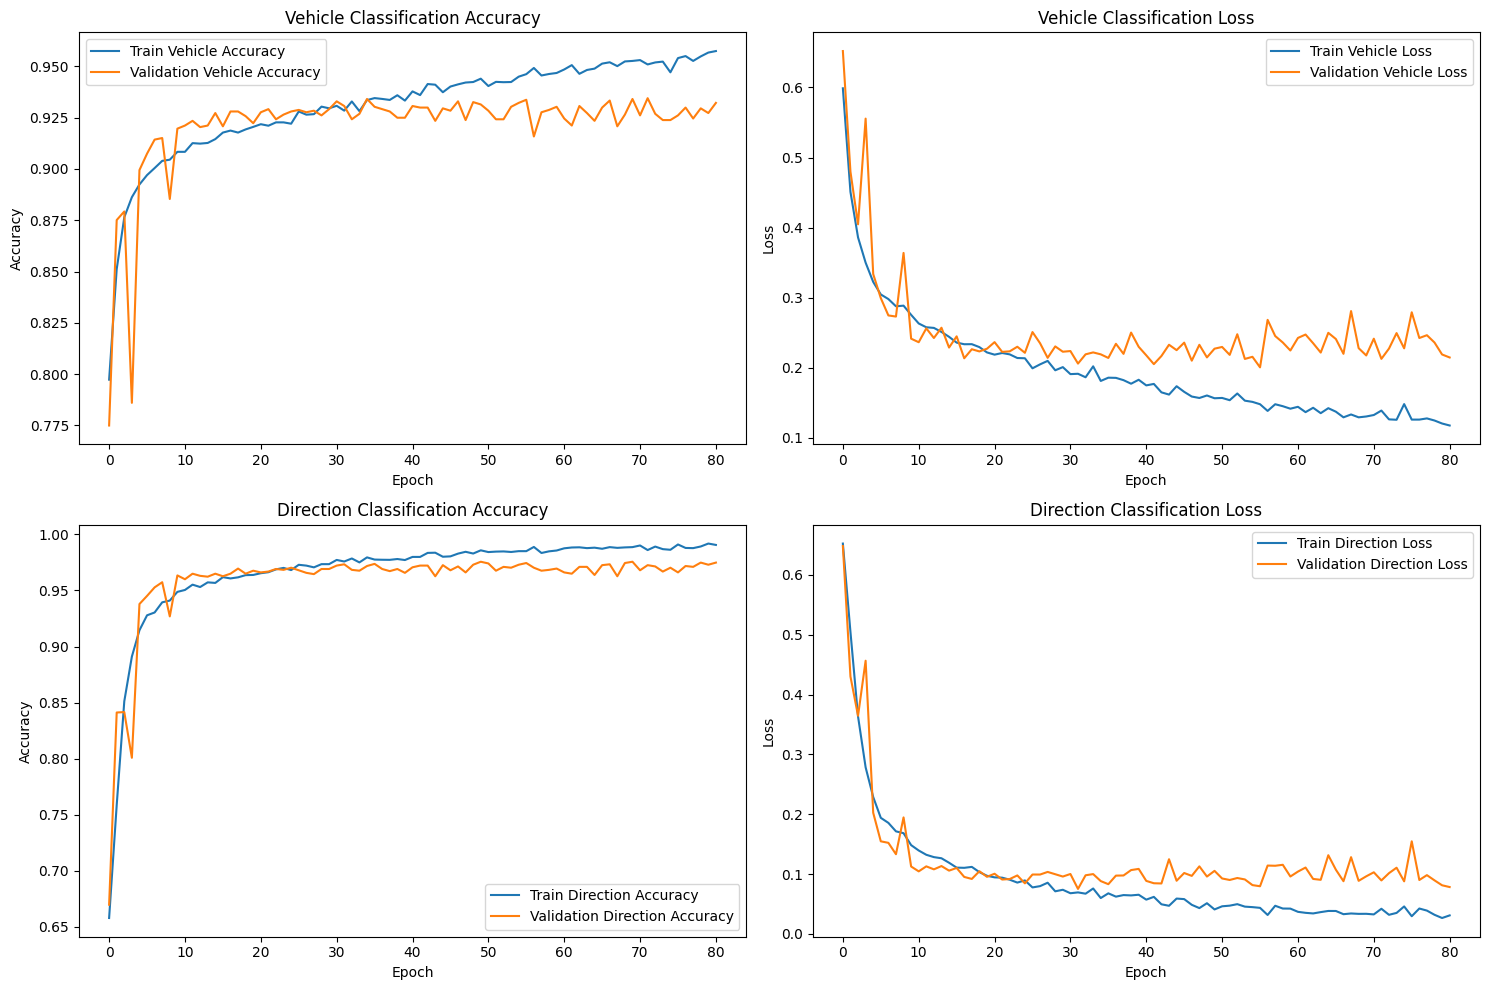


===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Miglior vehicle accuracy: 0.9345 (epoch 72)

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.86      0.27      0.41        22
           C       0.88      0.98      0.93      1177
           M       0.98      0.81      0.89        58
        None       0.98      0.98      0.98      1213
           T       0.57      0.20      0.30       156

    accuracy                           0.92      2626
   macro avg       0.86      0.65      0.70      2626
weighted avg       0.91      0.92      0.91      2626



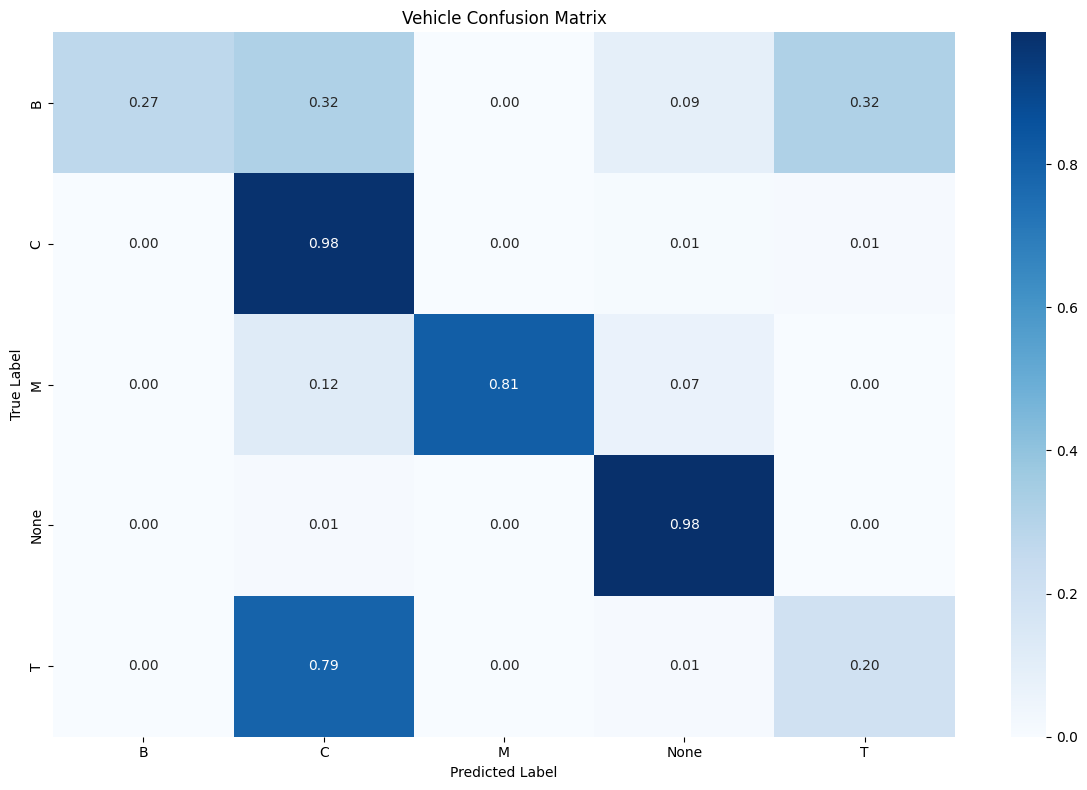


===== RISULTATI CLASSIFICAZIONE DIREZIONE =====
Miglior direction accuracy: 0.9756 (epoch 50)

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.98      0.96      0.97       715
        None       0.98      0.98      0.98      1213
           R       0.96      0.97      0.97       698

    accuracy                           0.98      2626
   macro avg       0.97      0.97      0.97      2626
weighted avg       0.98      0.98      0.98      2626



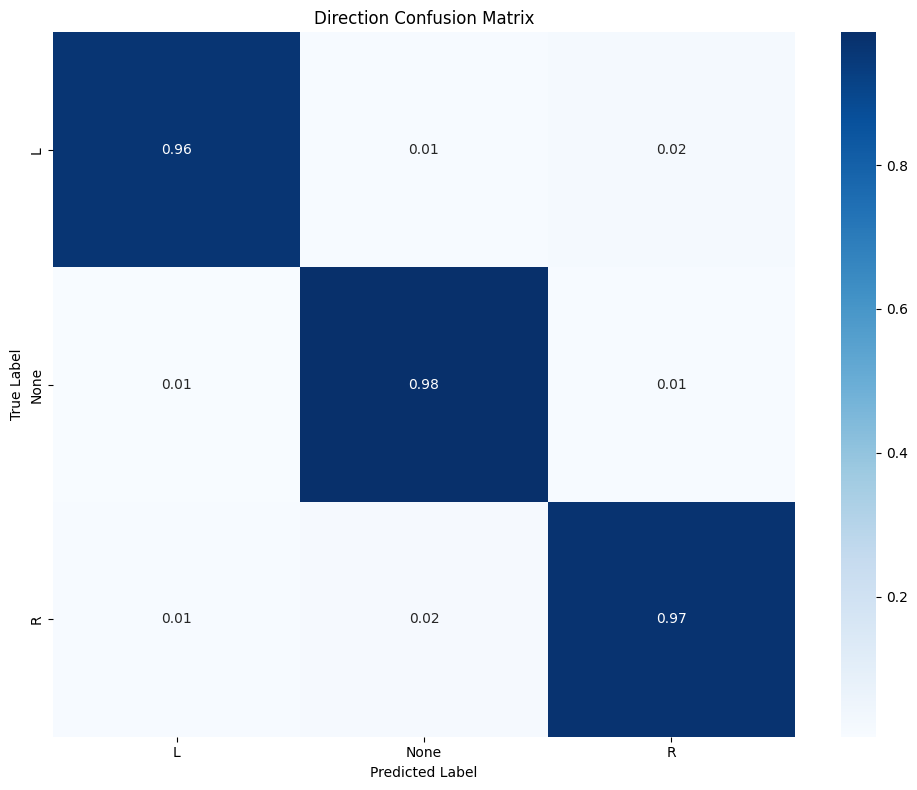

In [43]:
# Sostituisci le due chiamate separate con questa singola chiamata
plot_and_evaluate_multi_output_model(
    history_11,
    vehicle_true, vehicle_pred, le_vehicle.classes_,
    direction_true, direction_pred, le_direction.classes_
)


===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Vehicle accuracy: 0.9242
Vehicle loss: 0.2459

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.86      0.27      0.41        22
           C       0.88      0.98      0.93      1177
           M       0.98      0.81      0.89        58
        None       0.98      0.98      0.98      1213
           T       0.57      0.20      0.30       156

    accuracy                           0.92      2626
   macro avg       0.86      0.65      0.70      2626
weighted avg       0.91      0.92      0.91      2626



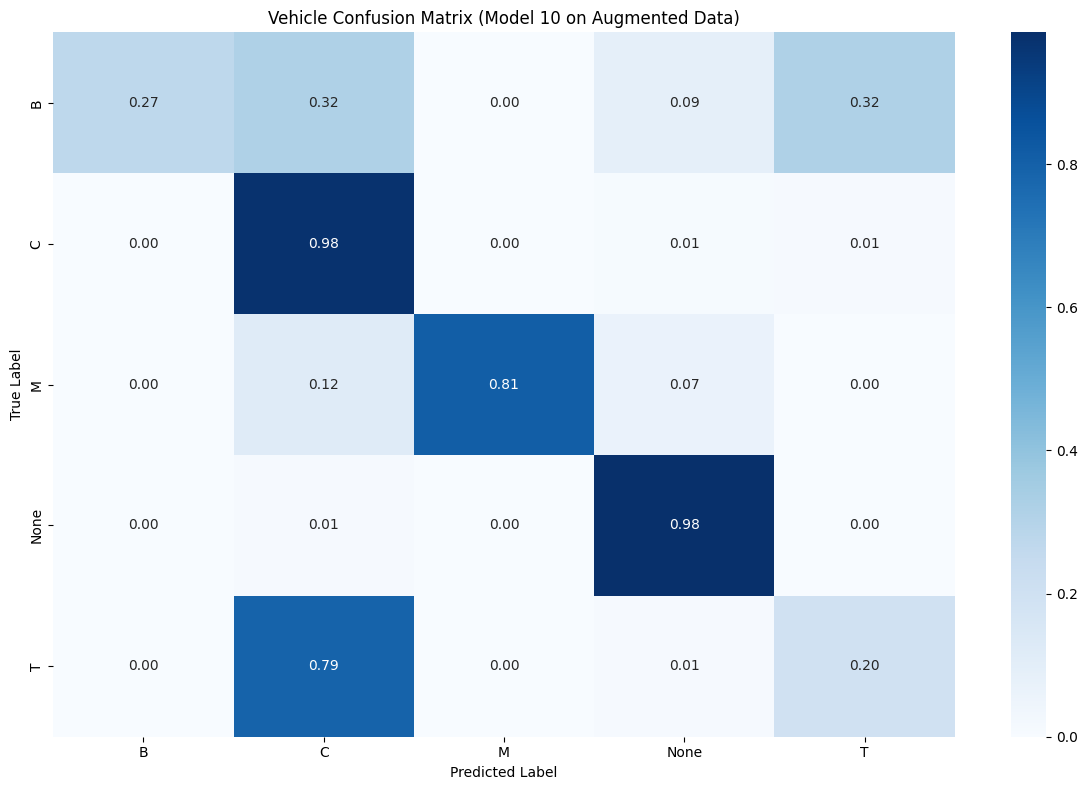


===== RISULTATI CLASSIFICAZIONE DIREZIONE =====
Direction accuracy: 0.9752
Direction loss: 0.0808

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.98      0.96      0.97       715
        None       0.98      0.98      0.98      1213
           R       0.96      0.97      0.97       698

    accuracy                           0.98      2626
   macro avg       0.97      0.97      0.97      2626
weighted avg       0.98      0.98      0.98      2626



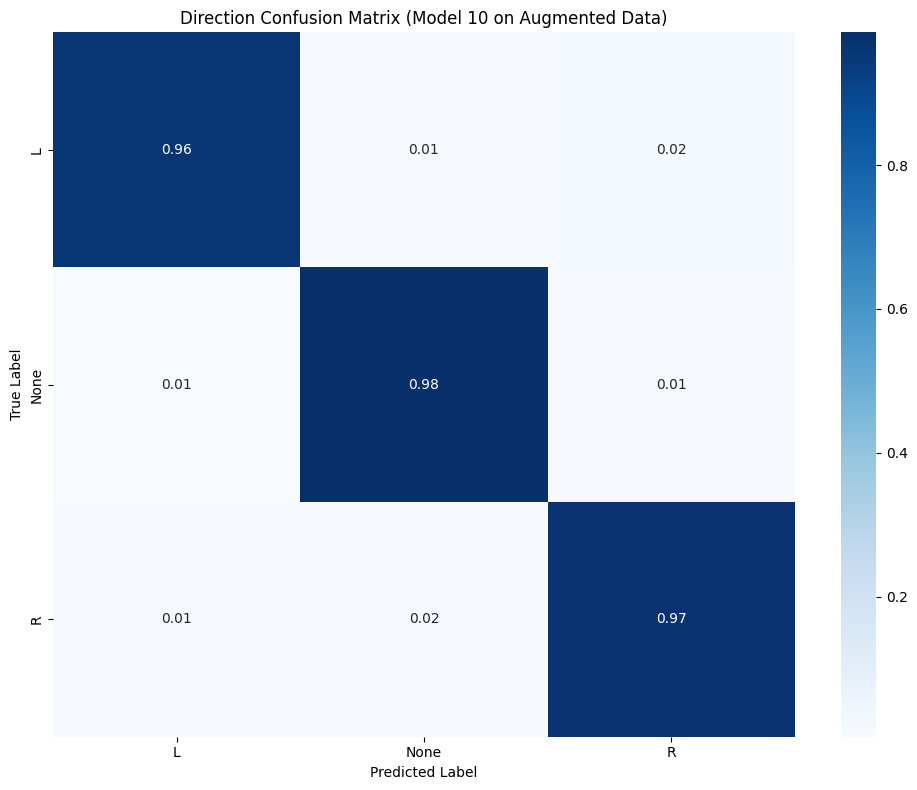

In [50]:
plot_test_results(
    vehicle_true, vehicle_pred, le_vehicle.classes_,
    direction_true, direction_pred, le_direction.classes_,
    test_results=results
)

In [45]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 10
# ------------------------------------------------------------------------------

'''
Come modello 9, ma doppio output per vehicle e direction

55 secondi a epoch
'''

# Definizione del modello

# 1. Ramo CNN per spettrogrammi
input_spectrogram = tf.keras.Input(shape=spectrograms_reshaped.shape[1:], name='spectrogram_input')

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(input_spectrogram)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Flatten()(x1)


# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)

# Fusione dei due rami
merged = tf.keras.layers.Concatenate()([x1, x2])

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(merged)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Output branch per i veicoli
vehicle_output = tf.keras.layers.Dense(5, activation='softmax', name='vehicle_output')(x)

# Output branch per la direzione (3 classi: left, right, none)
direction_output = tf.keras.layers.Dense(3, activation='softmax', name='direction_output')(x)


# Modello completo con doppio output
model_10 = tf.keras.Model(
    inputs=[input_spectrogram, input_features], 
    outputs=[vehicle_output, direction_output]
)

model_10.summary()


# Compilation con doppio obiettivo e perdita
model_10.compile(
    optimizer='adam',
    loss={
        'vehicle_output': 'categorical_crossentropy',
        'direction_output': 'categorical_crossentropy'
    },
    metrics={
        'vehicle_output': ['accuracy'],
        'direction_output': ['accuracy']
    },
    loss_weights={
        'vehicle_output': 1.0, 
        'direction_output': 1.0  # Puoi bilanciare l'importanza degli output
    }
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_10.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 128, 188,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 186,  │      1,216 │ spectrogram_inpu… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 93,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 63, 93,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 91,    │     36,928 │ dropout_7[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 45,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 30, 45,    │          0 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 43,    │     18,464 │ dropout_8[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 14, 21,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      1,664 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 14, 21,    │          0 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 19,    │      4,624 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      4,160 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 6, 9, 16)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,579,160 (6.02 MB)

 Trainable params: 1,579,160 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
'''
TEST CON MODELLO 10 SU DATASET AUGMENTED
'''

# TEST per modello multi-output
best_model_10 = tf.keras.models.load_model('best_model_10.h5')

# Valutazione del modello con entrambi gli output
results = best_model_10.evaluate(
    [X_test, audio_features_test],
    {
        'vehicle_output': y_test_vehicle,
        'direction_output': y_test_direction
    },
    verbose=1
)

# Estrai e stampa le metriche
print("\n--- Risultati test modello multi-output ---")
print(f"Loss totale: {results[0]:.4f}")
print(f"Vehicle output loss: {results[1]:.4f}")
print(f"Direction output loss: {results[2]:.4f}")
print(f"Vehicle accuracy: {results[3]:.4f}")
print(f"Direction accuracy: {results[4]:.4f}")

# Genera predizioni
y_pred_probs = best_model_10.predict([X_test, audio_features_test])
vehicle_pred_probs = y_pred_probs[0]  # Prima uscita: vehicle
direction_pred_probs = y_pred_probs[1]  # Seconda uscita: direction

# Converti probabilità in categorie
vehicle_pred = np.argmax(vehicle_pred_probs, axis=1)
direction_pred = np.argmax(direction_pred_probs, axis=1)
vehicle_true = np.argmax(y_test_vehicle, axis=1)
direction_true = np.argmax(y_test_direction, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - direction_output_accuracy: 0.9257 - direction_output_loss: 0.4338 - loss: 1.0247 - vehicle_output_accuracy: 0.8832 - vehicle_output_loss: 0.5911

--- Risultati test modello multi-output ---
Loss totale: 1.0246
Vehicle output loss: 0.5987
Direction output loss: 0.4367
Vehicle accuracy: 0.9208
Direction accuracy: 0.8728
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step



===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Vehicle accuracy: 0.8728
Vehicle loss: 0.5987

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.48      0.55      0.51        22
           C       0.89      0.87      0.88      1177
           M       0.84      0.81      0.82        58
        None       0.88      0.98      0.93      1213
           T       0.65      0.15      0.25       156

    accuracy                           0.87      2626
   macro avg       0.75      0.67      0.68      2626
weighted avg       0.86      0.87      0.86      2626



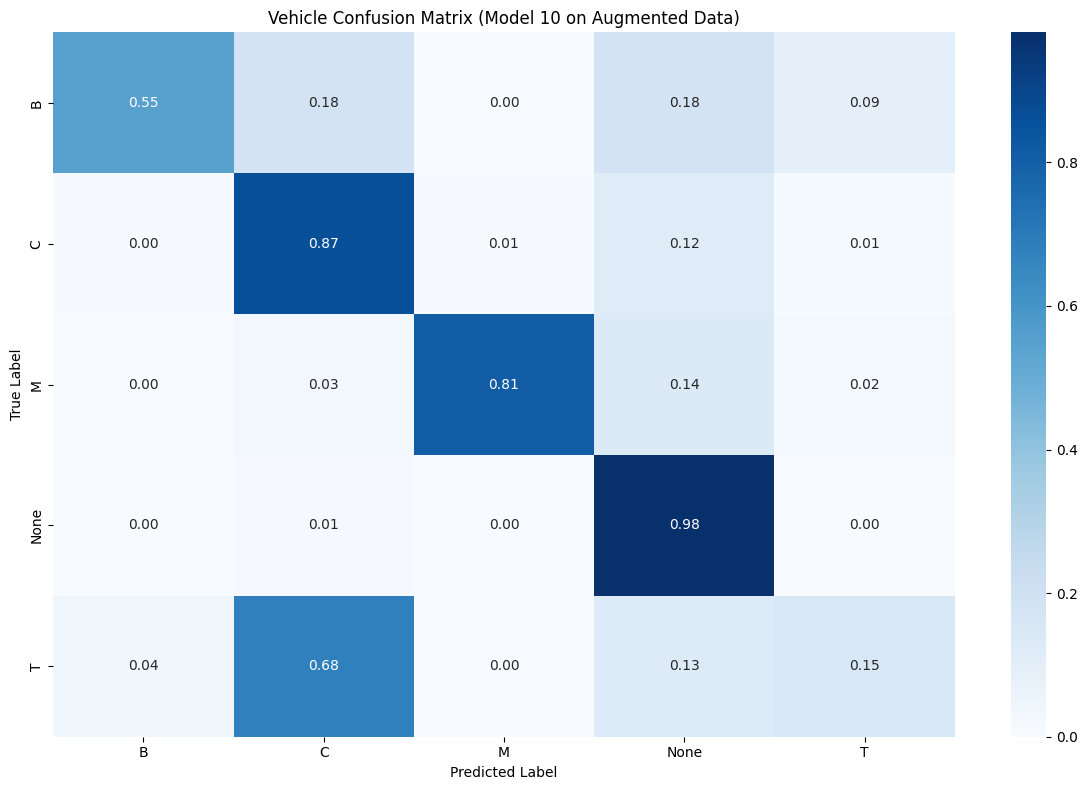


===== RISULTATI CLASSIFICAZIONE DIREZIONE =====
Direction accuracy: 0.9208
Direction loss: 0.4367

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.97      0.86      0.91       715
        None       0.88      0.98      0.93      1213
           R       0.96      0.88      0.92       698

    accuracy                           0.92      2626
   macro avg       0.94      0.91      0.92      2626
weighted avg       0.93      0.92      0.92      2626



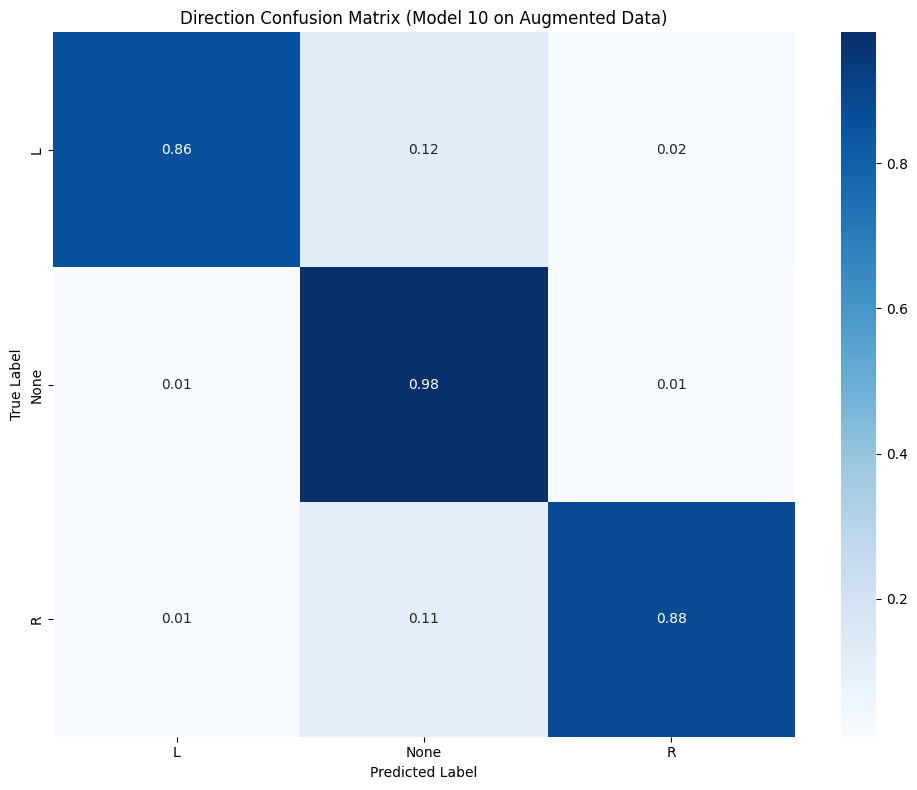

In [48]:
plot_test_results(
    vehicle_true, vehicle_pred, le_vehicle.classes_,
    direction_true, direction_pred, le_direction.classes_,
    test_results=results
)